# A Finite Element Examples: Frame 01

This example is based on the frame01 example distributed with FEM.edu

## Load needed components

We need to add the local code to the path or python won't find FEM.edu

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join("..")))

Now load the needed components of FEM.edu

In [2]:
from femedu.domain import *
from femedu.solver.NewtonRaphsonSolver import *
from femedu.elements.Frame2D import *
from femedu.materials.ElasticSection import *

## Build a model

In [3]:
# ========== setting mesh parameters ==============

N = 8                                   # number of elements in the mesh

# do not use alpha = 0 or your model will have elements with length = 0.0 and the axial direction is undefined.
alpha=np.linspace(0.05,.95,10)          # alpha value

L = 100.0                               # column free length


# ========== setting material parameters ==============

params = dict(
    E = 20000.,    # Young's modulus
    A = 100.0,     # cross section area
    I = 10.0       # cross section moment of inertia
    #gamma=2
)

# ========== setting load parameters ==============

w   = 0.01        # uniform lateral load on the column
Pcr = np.pi**2 * params['E'] * params['I'] / L**2    # Euler buckling load

# ========== setting analysis parameters ==============

target_load_level = 0.99      # 99% of Euler load
max_steps = 10                # solve max_steps points on the primary path


w   *= 0.01
#Pcr *= 0.01    # PETER SAYS: I turned that off


# define a list of target load levels
load_levels = np.linspace(0, target_load_level, max_steps)

#
# ==== Build the system model ====
#

model = []

for a in range(10):
    model.append(System())

    model[a].setSolver(NewtonRaphsonSolver())

    # create nodes

    nd0 = Node(0.0, 0.0)

    model[a] += nd0


    ndi = nd0

    y=0

    #params['E']
    for i in range(N):
        # nodes
        y+=(alpha[a])*L/N
        ndj = Node(0.0, y)  
        model[a] += ndj

        # elements
        elem = Frame2D(ndi, ndj, ElasticSection(params))
        model[a] += elem

        # ** apply the element portion of the reference load
        elem.setDistLoad(w)

        ndi = ndj    # jump to next element: make current end-node the next start-node

    #params['E']=
    for i in range(N):
        # nodes
        y+=(1-alpha[a])*L/N
        ndj = Node(0.0, y)  
        model[a] += ndj

        # elements
        elem = Frame2D(ndi, ndj, ElasticSection(params))
        model[a] += elem

        # ** apply the element portion of the reference load
        elem.setDistLoad(w)

        ndi = ndj    # jump to next element: make current end-node the next start-node
                 
    #params['E']
    for i in range(N):
        # nodes
        y+=((1-alpha[a])/2*L/N)
        ndj = Node(0.0,y)  
        model[a] += ndj
    
        # elements
        elem = Frame2D(ndi, ndj, ElasticSection(params))
        model[a] += elem

        # ** apply the element portion of the reference load
        elem.setDistLoad(w)

        ndi = ndj    # jump to next element: make current end-node the next start-node
                 
    # define support(s)

    nd0.fixDOF('ux', 'uy')    # horizontal support left end
    ndi.fixDOF('ux')          # vertical support right end

    # ==== complete the reference load ====

    # these are only nodal forces as part of the reference load
    # .. load only the upper node
    ndi.setLoad((-Pcr,), ('uy',))



## Analyze the model

In [4]:

model[9].solve(verbose=True)

model[9].report()


norm of the out-of-balance force:   1.9739e+02
norm of the out-of-balance force:   3.4081e-03
norm of the out-of-balance force:   1.3329e-07
+

System Analysis Report

Nodes:
---------------------
  Node_0:
      x:    [0. 0.]
      fix:  ['ux', 'uy']
      u:    [ 0.          0.         -0.00043638]
  Node_1:
      x:    [ 0.    11.875]
      u:    [ 0.00506936 -0.00117202 -0.00040801]
  Node_2:
      x:    [ 0.   23.75]
      u:    [ 0.009478   -0.00234403 -0.00032626]
  Node_3:
      x:    [ 0.    35.625]
      u:    [ 0.0126471  -0.00351605 -0.00020154]
  Node_4:
      x:    [ 0.  47.5]
      u:    [ 1.41585325e-02 -4.68806209e-03 -5.01765184e-05]
  Node_5:
      x:    [ 0.    59.375]
      u:    [ 0.01381238 -0.00586008  0.00010782]
  Node_6:
      x:    [ 0.   71.25]
      u:    [ 0.01165446 -0.00703209  0.00025156]
  Node_7:
      x:    [ 0.    83.125]
      u:    [ 0.00797    -0.00820411  0.00036208]
  Node_8:
      x:    [ 0. 95.]
      u:    [ 0.0032444  -0.00937612  0.000425

# create plots
print(model)

model.setLoadFactor(0.5)
model.solve()
print(model)
        
model.plot(factor=10000.0)

model.beamValuePlot("F")
model.beamValuePlot("M")
model.beamValuePlot("V")

## Stability Analysis

In [14]:
# initialize the analysis:

lambdas = [ [] for i in range(10) ]  # create an empty list of lambdas for each model!
detKts  = [ [] for i in range(10) ]  # create an empty list of det(Kt)s for each model!

# loop through your models
for i in range(10):
    
    # now analyze the i-th model
    for load_level in load_levels:
        
        # Kt   = []
        model[i].resetDisplacements()                # set U to all zeros
        model[i].setLoadFactor(load_level)           # WAS WRONG: define a known equilibrium solution
        # This sets the target load level.  
        # - It should be an equilibrium state (if no thermal or plastic loads are present)
        # - but you need to call model.solve() to assemble internal force (equilibrium check) and Kt

        #Kt=model[i].getSolver(assemble())
        #lambdas[i]=Kt.getBucklingMode(mode=0)

        model[i].solve()                           # you need to find the primary path first
        detKt = model[i].solver.checkStability()   # stability check: returns detKt for small systems, min eigenvalue for larger ones

        # the current lambda is 0.0 (your target load factor)
        lambdas[i].append(load_level)
        detKts[i].append(detKt)
        
        if detKt < 0.0:   # PETER SAYS: this load level went just past the critical one!
            break         # ... stop applying more load - you have everything you need

        #model.startRecorder()        # not doing anything yet, but will do the data collection soon

        #detKt   = []
        #lambdas = []
        
    # PETER SAYS: At this point, you have a load-history dataset for model[i]
    # ... this would be the perfect spot to extrapolate/interpolate detKt for the i-th model 
    # ... and find the critical lambda
    

# solve for all load_levels
"""for loadfactor in load_levels:

    # define node X2 as the controled node; downward direction is prescribed:
    model.setLoadFactor(loadfactor)
    model.solve(verbose=True)

    # stability check
    lambdas.append(model.loadfactor)
    detKt.append(model.solver.checkStability())

    # report results
    print('+')
    #model.report()

    print("\n=== next load level ===\n")"""


norm of the out-of-balance force:   1.9542e+02
norm of the out-of-balance force:   1.9582e-12
+

 ** Stability check: (smallest eigenvalue of Kt) = 0.4118564120047467

norm of the out-of-balance force:   2.1713e+01
norm of the out-of-balance force:   9.8469e-05
norm of the out-of-balance force:   4.1040e-10
+

 ** Stability check: (smallest eigenvalue of Kt) = 0.31351695890647213

norm of the out-of-balance force:   2.1713e+01
norm of the out-of-balance force:   2.5910e-04
norm of the out-of-balance force:   7.7339e-09
+

 ** Stability check: (smallest eigenvalue of Kt) = 0.21505011102790952

norm of the out-of-balance force:   2.1713e+01
norm of the out-of-balance force:   5.6757e-04
norm of the out-of-balance force:   8.3794e-12
+

 ** Stability check: (smallest eigenvalue of Kt) = 0.11643702009684206

norm of the out-of-balance force:   2.1713e+01
norm of the out-of-balance force:   1.4003e-03
norm of the out-of-balance force:   1.2125e-07
+

 ** Stability check: (smallest eigenvalu

norm of the out-of-balance force:   6.6884e-12
+

 ** Stability check: (smallest eigenvalue of Kt) = -0.07834513675549287

norm of the out-of-balance force:   1.9542e+02
norm of the out-of-balance force:   5.0416e-12
+

 ** Stability check: (smallest eigenvalue of Kt) = 0.5989421169119298

norm of the out-of-balance force:   2.1713e+01
norm of the out-of-balance force:   4.2473e-05
norm of the out-of-balance force:   2.0377e-11
+

 ** Stability check: (smallest eigenvalue of Kt) = 0.5084013499818993

norm of the out-of-balance force:   2.1713e+01
norm of the out-of-balance force:   1.0019e-04
norm of the out-of-balance force:   3.5816e-12
+

 ** Stability check: (smallest eigenvalue of Kt) = 0.4177321515417379

norm of the out-of-balance force:   2.1713e+01
norm of the out-of-balance force:   1.8313e-04
norm of the out-of-balance force:   4.2426e-11
+

 ** Stability check: (smallest eigenvalue of Kt) = 0.32692189125803317

norm of the out-of-balance force:   2.1713e+01
norm of the out-

'for loadfactor in load_levels:\n\n    # define node X2 as the controled node; downward direction is prescribed:\n    model.setLoadFactor(loadfactor)\n    model.solve(verbose=True)\n\n    # stability check\n    lambdas.append(model.loadfactor)\n    detKt.append(model.solver.checkStability())\n\n    # report results\n    print(\'+\')\n    #model.report()\n\n    print("\n=== next load level ===\n")'

In [20]:
# these are the recorded load levels for each model:
lambdas

[[0.0, 0.11, 0.22, 0.33, 0.44, 0.55],
 [0.0, 0.11, 0.22, 0.33, 0.44, 0.55],
 [0.0, 0.11, 0.22, 0.33, 0.44, 0.55],
 [0.0, 0.11, 0.22, 0.33, 0.44, 0.55, 0.66],
 [0.0, 0.11, 0.22, 0.33, 0.44, 0.55, 0.66],
 [0.0, 0.11, 0.22, 0.33, 0.44, 0.55, 0.66, 0.77],
 [0.0, 0.11, 0.22, 0.33, 0.44, 0.55, 0.66, 0.77],
 [0.0, 0.11, 0.22, 0.33, 0.44, 0.55, 0.66, 0.77, 0.88],
 [0.0, 0.11, 0.22, 0.33, 0.44, 0.55, 0.66, 0.77, 0.88],
 [0.0, 0.11, 0.22, 0.33, 0.44, 0.55, 0.66, 0.77, 0.88, 0.99]]

In [21]:
# these are the recorded detKts (or eigenvalues) for each model:
detKts

[[0.4118564120047467,
  0.31351695890647213,
  0.21505011102790952,
  0.11643702009684206,
  0.01765507038846372,
  -0.0813233333416077],
 [0.4246474745384643,
  0.32992628693885717,
  0.23513589019752737,
  0.1402687761623642,
  0.04531615437638417,
  -0.04973235504234731],
 [0.4296427147669623,
  0.34037379846553173,
  0.2510638330428121,
  0.16171004927694457,
  0.0723093857861184,
  -0.017141543111267095],
 [0.43635985844639186,
  0.35214460753462484,
  0.2679050829820446,
  0.18363985391415008,
  0.0993473733747148,
  0.015025966983715914,
  -0.06932618215054855],
 [0.4562447859074069,
  0.37468451062132524,
  0.293114176513863,
  0.2115331830517344,
  0.12994087836781912,
  0.04833654377257865,
  -0.03328061127050632],
 [0.5029361421471265,
  0.4200087586032805,
  0.33704997978418083,
  0.25405661324928097,
  0.17102499250885364,
  0.08795089360686414,
  0.004829421694641757,
  -0.07834513675549287],
 [0.5989421169119298,
  0.5084013499818993,
  0.4177321515417379,
  0.3269218912

### Summary

The following plot shows detKt over applied load level for your 10 models.

You will need the following to complete the stability analysis for all of these:

* extrapolate (or interpolate) $det{\bf K}_t$ and find where it goes through zero. That $\lambda$ is your $\lambda_{cr}$.
* collect those $\lambda_{cr}$ for each model and plot $\lambda_{cr}$ over $\alpha$ and you have the reuested stability graph.

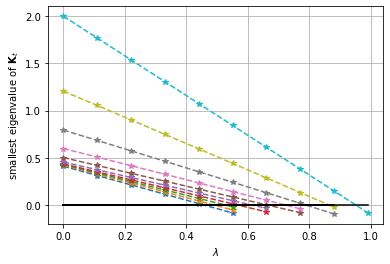

In [18]:
for lam, dKt in zip(lambdas, detKts):
    
    plt.plot(lam, dKt, '--*')

    # add a black zero line
    plt.plot(lam, np.zeros_like(lam), '-k')

plt.xlabel("$\lambda$")
plt.ylabel("smallest eigenvalue of ${\\bf K}_t$")
plt.grid(True)
plt.show()

This looks like those curces are (or nearly are) linear.  You can find the critical value by interpolating between the last two values.

Interpolation works as
$$
   f(\lambda) = \frac{\lambda_1 - \lambda}{\lambda_1 - \lambda_0}\,f_0 
    + \frac{\lambda - \lambda_0}{\lambda_1 - \lambda_0}\,f_1 
$$
and $\lambda_{cr}$ follows from
$$
    f(\lambda_{cr}) = 0 
    \qquad\Rightarrow\qquad
    \lambda_{cr} = \dots
$$

Here is how to fetch those values for model `i`:
```
# pick a model:
i = 1

lam0 = lambdas[i][-2]  # second to last in the list
lam1 = lambdas[i][-1]  # last in the list

f0 = lambdas[i][-2]  # second to last in the list
f1 = lambdas[i][-1]  # last in the list
```


In [13]:
#
# ==== check the current state of the model ===
#

for mod in model:
    mod.report()


System Analysis Report

Nodes:
---------------------
  Node_0:
      x:    [0. 0.]
      fix:  ['ux', 'uy']
      u:    [ 0.00000000e+00  0.00000000e+00 -5.53083694e-05]
  Node_1:
      x:    [0.    0.625]
      u:    [ 3.45670142e-05 -6.10681772e-05 -5.53049246e-05]
  Node_2:
      x:    [0.   1.25]
      u:    [ 6.91297038e-05 -1.22136354e-04 -5.52945108e-05]
  Node_3:
      x:    [0.    1.875]
      u:    [ 1.03683676e-04 -1.83204532e-04 -5.52770112e-05]
  Node_4:
      x:    [0.  2.5]
      u:    [ 1.38224468e-04 -2.44272709e-04 -5.52523116e-05]
  Node_5:
      x:    [0.    3.125]
      u:    [ 1.72747543e-04 -3.05340886e-04 -5.52203006e-05]
  Node_6:
      x:    [0.   3.75]
      u:    [ 2.07248298e-04 -3.66409063e-04 -5.51808696e-05]
  Node_7:
      x:    [0.    4.375]
      u:    [ 2.41722062e-04 -4.27477241e-04 -5.51339127e-05]
  Node_8:
      x:    [0. 5.]
      u:    [ 2.76164099e-04 -4.88545418e-04 -5.50793271e-05]
  Node_9:
      x:    [ 0.    16.875]
      u:    [ 9.17820

In [ ]:
#
# ==== create some nice plots ===
#

plt.plot(lambdas,detKt,'--*r')
plt.grid(True)
plt.xlabel('Load factor, $ \lambda $')
plt.ylabel("Stability index, $ {det}\: {\\bf K}_t $")
plt.show()

model.plot(factor=1.0)

model.beamValuePlot("F")
model.beamValuePlot("M")
model.beamValuePlot("V")

model.plotBucklingMode(factor=10.)
